#FastText

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fasttext
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm  # To measure the progress meters we have imported tqdm

In [ ]:
size = 50
maximum_words_len = 50

In [ ]:
df = pd.read_csv('spam_ham_dataset1.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
#Assignining here
df["text"] = df.text
df["spam"] = df.label

In [ ]:
df.head()

,Unnamed: 0,label,text,label_num,spam
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,ham
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,ham
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,ham
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,spam
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,ham


In [ ]:
#dropping
df.dropna(inplace = True)
df['text'] = df['text'].str.replace(r'\d','number')
df['text'] = df['text'].str.replace(r'[^a-zA-Z]', ' ', regex = True)
df['text'] = df['text'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex = True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex = True).map(lambda x:x.lower())

In [ ]:
#cleaned data printing
df.head()

,Unnamed: 0,label,text,label_num,spam
0,605,ham,subject enron methanol meter numbernumbernumbe...,0,ham
1,2349,ham,subject hpl nom for january number numbernumbe...,0,ham
2,3624,ham,subject neon retreat ho ho ho we re around to ...,0,ham
3,4685,spam,subject photoshop windows office cheap main tr...,1,spam
4,2030,ham,subject re indian springs this deal is to book...,0,ham


In [ ]:
#Opening corpusfile
with open(r'spamcorpusfile.txt', 'w') as txtfile:
    for i in range(len(df)):
        line = df.loc[i,'text']
        txtfile.write(line)
        txtfile.write('\n')

In [ ]:
#Training using skipgram
model = fasttext.train_unsupervised('spamcorpusfile.txt',
                                    minCount = 5, 
                                    model='skipgram',
                                    minn = 2,
                                    maxn = 5,
                                    dim = size,
                                    lr = 0.1,
                                    epoch = 20)

In [ ]:
with open(r'spamcorpusfile.txt', 'r', encoding="utf-8") as txtfile:
    sentences = txtfile.readlines()
    words = []
    for sent in sentences:
        tokenized_sent = sent.split() #tokenized 
        for word_ in tokenized_sent:
            words.append(word_)
            
    corpus_unique_words = list(set(words))

In [ ]:
#vectors
with open(r'fasttext_embeddings_file.txt', 'w', encoding="utf-8") as txtfile:
    txtfile.write(str(len(corpus_unique_words)) + " " + str(model.get_dimension()))
    txtfile.write('\n') 
    for word in corpus_unique_words:         #extracting the unique words
        embedding = model.get_word_vector(word)
        vstr = ""
        for vi in embedding:
            vstr += " " + str(vi)
        txtfile.write(word + vstr)  
        txtfile.write('\n')

In [ ]:
num_words = len(corpus_unique_words) 
tokenizer = Tokenizer(num_words+1, oov_token = 'UNK') # tagging the words which missing the corpus dat vocabulary as UNk
tokenizer.fit_on_texts(df['text'])

In [ ]:
vocab_size = len(tokenizer.word_index)+1     # adding 1 to rpresent every word has occured the file
matrix = np.zeros(shape = (vocab_size , size))

for word, index in tqdm(tokenizer.word_index.items()):
    matrix[index] = model.get_word_vector(word)

100%|██████████| 45788/45788 [00:00<00:00, 91618.03it/s]


In [ ]:
X = tokenizer.texts_to_sequences(df['text'])

In [ ]:
X = pad_sequences(X, padding = 'post', maxlen = maximum_words_len, truncating='post')

In [ ]:
Y = pd.get_dummies(df['spam'])['spam'].values

In [ ]:
#trained nad tested
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, stratify = Y) #stratified the test dat to avoid overlapping while testing

In [ ]:
def model_creation():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, size, 
                                weights=[matrix], 
                                input_length=maximum_words_len , 
                                trainable=True)
    
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
model = model_creation()

early_stopping = EarlyStopping(monitor= 'val_acc', 
                               mode = 'max',
                               patience=30, 
                               verbose=1)

model_checkpoint = ModelCheckpoint('SPAM_CLASSIFIER',
                                   monitor = 'val_acc', # for monitoring we used the validation accuracy, mode set to max
                                   mode = 'max', 
                                   save_best_only=True, 
                                   verbose=1)


opt = Adam(learning_rate = 0.01) #learning rate to increase the effieciency of learning

model.compile(opt, loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
fitted_model = model.fit(x_train, 
                    y_train, 
                    validation_data=[x_test, y_test],
                    batch_size=32,
                    epochs=20,
                    callbacks = [early_stopping, model_checkpoint])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9360

146/146 [==============================] - 5s 15ms/step - loss: 0.1496 - accuracy: 0.9360 - val_loss: 0.0512 - val_accuracy: 0.9807
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9931

146/146 [==============================] - 1s 10ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0429 - val_accuracy: 0.9865
Epoch 3/20
143/146 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

146/146 [==============================] - 1s 10ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0505 - val_accuracy: 0.9884
Epoch 4/20
145/146 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

146/146 [==============================] - 1s 10ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0670 - val_accuracy: 0.9865
Epoch 5/20
142/146 [============================>.] - ETA: 0s - loss: 8.0820e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 8.2335e-05 - accuracy: 1.0000 - val_loss: 0.0697 - val_accuracy: 0.9865
Epoch 6/20
144/146 [============================>.] - ETA: 0s - loss: 3.8756e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 4.3558e-05 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 0.9865
Epoch 7/20
143/146 [============================>.] - ETA: 0s - loss: 2.9345e-05 - accuracy: 1.0000

146/146 [==============================] - 2s 10ms/step - loss: 2.9185e-05 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.9865
Epoch 8/20
142/146 [============================>.] - ETA: 0s - loss: 2.1624e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 2.1438e-05 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.9884
Epoch 9/20
144/146 [============================>.] - ETA: 0s - loss: 1.6446e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 1.6361e-05 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9884
Epoch 10/20
142/146 [============================>.] - ETA: 0s - loss: 1.3123e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 1.2977e-05 - accuracy: 1.0000 - val_loss: 0.0800 - val_accuracy: 0.9884
Epoch 11/20
145/146 [============================>.] - ETA: 0s - loss: 1.0609e-05 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 1.0595e-05 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9884
Epoch 12/20
141/146 [===========================>..] - ETA: 0s - loss: 8.8124e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 8.7716e-06 - accuracy: 1.0000 - val_loss: 0.0828 - val_accuracy: 0.9884
Epoch 13/20
142/146 [============================>.] - ETA: 0s - loss: 7.3883e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 7.3439e-06 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9884
Epoch 14/20
145/146 [============================>.] - ETA: 0s - loss: 6.2325e-06 - accuracy: 1.0000

146/146 [==============================] - 2s 10ms/step - loss: 6.2266e-06 - accuracy: 1.0000 - val_loss: 0.0853 - val_accuracy: 0.9884
Epoch 15/20
146/146 [==============================] - ETA: 0s - loss: 5.3531e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 5.3531e-06 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9884
Epoch 16/20
143/146 [============================>.] - ETA: 0s - loss: 4.6799e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 4.6441e-06 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 0.9884
Epoch 17/20
142/146 [============================>.] - ETA: 0s - loss: 3.9977e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 4.0480e-06 - accuracy: 1.0000 - val_loss: 0.0886 - val_accuracy: 0.9884
Epoch 18/20
142/146 [============================>.] - ETA: 0s - loss: 3.5954e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 3.5615e-06 - accuracy: 1.0000 - val_loss: 0.0897 - val_accuracy: 0.9884
Epoch 19/20
143/146 [============================>.] - ETA: 0s - loss: 3.1395e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 3.1378e-06 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 0.9884
Epoch 20/20
141/146 [===========================>..] - ETA: 0s - loss: 2.7965e-06 - accuracy: 1.0000

146/146 [==============================] - 1s 10ms/step - loss: 2.7820e-06 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9884


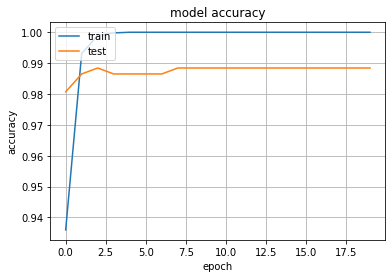

In [ ]:
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test)]

17/17 [==============================] - 1s 5ms/step


In [ ]:
cf_matrix =confusion_matrix(y_test,y_predict)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

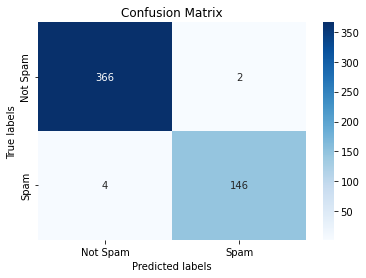

In [ ]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [ ]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))

Precision: 98.65%
Recall: 97.33%
F1 Score: 97.99%


In [ ]:
f1_score(y_test,y_predict)

0.9798657718120806